In [2]:
import ssl
# SSL 인증서 검증 예외 처리: 네트워크가 자체 CA를 사용하거나 내부망일 때 사용
# (실제 운영 환경에서는 보안 위험이 있으므로 주의)
ssl._create_default_https_context = ssl._create_unverified_context

# --- 데이터·모델 관련 라이브러리 임포트 ---
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as sk_datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [4]:
# 1. 하이퍼파라미터
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-3

In [6]:
# 2. 데이터 로드 및 전처리
# - sklearn 손글씨 숫자 데이터셋 사용 (8x8 이미지)
digits = sk_datasets.load_digits()
X = digits.images          # (1797, 8, 8)
y = digits.target.reshape(-1, 1)  # (1797, 1)

In [8]:
# 2.1 정규화: 픽셀값을 [0, 1] 범위로 스케일
X = X / 16.0

In [10]:

# 2.2 채널 차원 추가 (PyTorch CNN 입력은 N, C, H, W)
X = X[:, np.newaxis, :, :]  # (N, 1, 8, 8)

In [12]:
# 2.3 라벨 원-핫 인코딩
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)  # (1797, 10)

In [14]:
# 2.4 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

In [16]:
# 2.5 PyTorch 텐서로 변환
X_train = torch.FloatTensor(X_train)
X_test  = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test  = torch.FloatTensor(y_test)

In [18]:
# 2.6 ResNet 입력에 맞춰 채널 복제 (1채널→3채널)
X_train = X_train.repeat(1, 3, 1, 1)  # (N, 3, 8, 8)
X_test  = X_test.repeat(1, 3, 1, 1)

In [20]:
# 3. DataLoader 준비
train_dataset = TensorDataset(X_train, y_train)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [22]:
# 4. 사전 학습된 ResNet18 모델 불러오기 및 마지막 레이어 수정
# - weights=None 으로 하면 다운로드 없이 초기화된 가중치 사용 가능
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 10)  # 분류 레이어: 10 클래스

In [24]:
# 5. 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류용 교차 엔트로피
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [26]:
# 6. 모델 학습
model.train()
for epoch in range(1, EPOCHS + 1):
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        # OneHot → class index 변환
        labels = torch.max(batch_y, dim=1)[1]
        outputs = model(batch_x)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}/{EPOCHS} - Loss: {total_loss:.4f}")

Epoch 1/20 - Loss: 58.8922
Epoch 2/20 - Loss: 27.6310
Epoch 3/20 - Loss: 18.2553
Epoch 4/20 - Loss: 18.2114
Epoch 5/20 - Loss: 13.5687
Epoch 6/20 - Loss: 14.8205
Epoch 7/20 - Loss: 11.0391
Epoch 8/20 - Loss: 8.5164
Epoch 9/20 - Loss: 7.2596
Epoch 10/20 - Loss: 5.2735
Epoch 11/20 - Loss: 7.0591
Epoch 12/20 - Loss: 3.2236
Epoch 13/20 - Loss: 6.6185
Epoch 14/20 - Loss: 5.7737
Epoch 15/20 - Loss: 6.7878
Epoch 16/20 - Loss: 7.6845
Epoch 17/20 - Loss: 5.2285
Epoch 18/20 - Loss: 5.6695
Epoch 19/20 - Loss: 4.3835
Epoch 20/20 - Loss: 3.5598


In [28]:
# 7. 평가 모드 및 예측 수행
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    y_pred = torch.argmax(outputs, dim=1)
    y_true = torch.argmax(y_test, dim=1)

In [30]:
# 8. 정확도 및 분류 리포트 출력
accuracy = metrics.accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(metrics.classification_report(y_true, y_pred, zero_division=0))

Test Accuracy: 0.9861
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      0.96      0.98        28
           2       0.94      1.00      0.97        33
           3       1.00      0.97      0.99        34
           4       1.00      0.98      0.99        46
           5       0.98      1.00      0.99        47
           6       0.97      1.00      0.99        35
           7       0.97      1.00      0.99        34
           8       1.00      0.97      0.98        30
           9       1.00      0.97      0.99        40

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



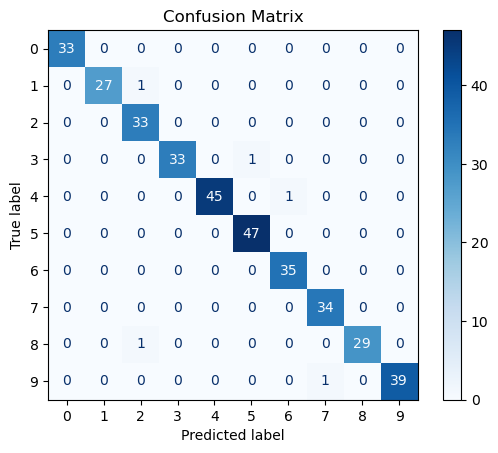

In [32]:
# 9. 혼동 행렬 시각화
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

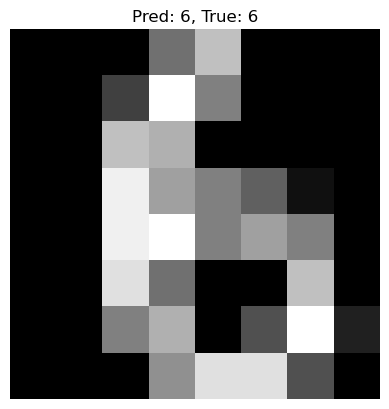

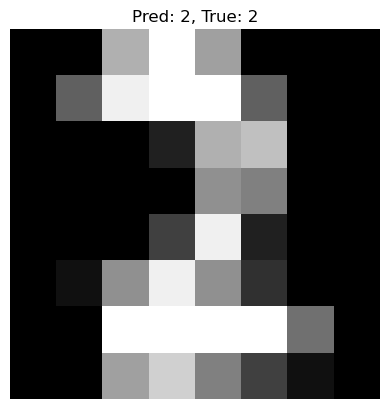

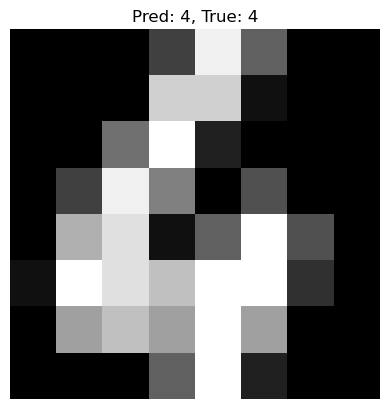

In [34]:
# 10. 몇 가지 예측 이미지 시각화
for idx in [0, 15, 30]:
    plt.figure()
    # 3채널 복제 전 1채널 이미지로 시각화
    plt.imshow(X_test[idx][0], cmap='gray')
    plt.title(f"Pred: {y_pred[idx].item()}, True: {y_true[idx].item()}")
    plt.axis('off')
    plt.show()